In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import os
import dhs_f
import fnmatch
import pyreadstat
import copy
from pandarallel import pandarallel
import time
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
###Options
#since_year = 2012
#drop south africa, egypt, tunesia, morocco
drop_countries = ['ZA', 'EG', 'TN', 'MA']
min_dhs_version = 6
#only extracts locations where these survey records are available #'HR' = household recode
additional_files = ['HH', 'HR']
###Paths
dhs_path = r"/mnt/datadisk/data/surveys/DHS_raw_data/"
#weighting of simplified water sources
drinking_water_source_weighting = 'drinking_water_source_weighting.csv'
projects_p = r"/mnt/datadisk/data/Projects/water/"
pickle_f = projects_p + '/pickle_tmp'
locations_f = projects_p + '/' + 'locations.csv'
#walk folder for finding .tifs
walk_f = r"/mnt/datadisk/"
# shannon_files = [r"/mnt/datadisk/data/Sentinel2/preprocessed/water/", ]
# stoermer_files = [r"/mnt/datadisk/data/Sentinel2/preprocessed/asset_wealth/"]
load_from_pickle = True
out_f = projects_p + '/water_labels.csv'

#Select based on keywords (sometimes the column names and column codes vary slightly)
#need 2 values for iterationg correctly
columns_to_keep_n_rename = {
                            ('month', 'interview'): 'month of interview', 
                            ('year', 'interview'): 'year of interview', 
                            ('total members in household', False): 'number of household members',
                            ('time', 'to', 'water source'): 'time to get to water source (minutes)',
                            ('location', 'source for water'): 'location of source for water', 
                            ('water', 'shortage'): 'water shortages',
                            ('water', 'not available'): 'water shortages'
                           }
#Select based on exact match
exact_match = {'case identification', 'country code and phase', 'cluster number', 'region', 'district', 
               'anything done to water to make safe to drink',
               'household number', 'number of household members', 'source of drinking water', 
               'source of non-drinking water'}
#actually keep these columns (after renaming and looking at completness of data)
#dropped everything with scarce data
named_columns_to_keep = ["case identification", "country code and phase", "cluster number", "household number",
                         "month of interview", "year of interview", "number of household members", "region", 
                         "source of drinking water", "GEID", "water shortages", 
                         "time to get to water source (minutes)", "location of source for water", 
                         "anything done to water to make safe to drink", "month of interview", 
                         "district", 'water shortages']
#calculate separately for urban/rural
split_urban_rural = True
#calcualte only for available s2 data
limit_calc_on_available_s2img = True
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

In [4]:
###load data, preselect water columns and save into pickle for faster reloading
#Note: Important to use meta files since column names and especially value labels are unambiguous
#unify column names and replace values
column_names_d = {}
bottled_d = {}
counter = 0
counter2 = {}
if not os.path.isfile(pickle_f) or not load_from_pickle:
    dhs_d_all, country_d, data_file_types_d, typ_l, dhs_dirs_d = \
        dhs_f.load_dhs_data(dhs_path)
    pathes = {}
    
    #catch all files
    for i, types in dhs_d_all.items():
        #only extract files where Household Recode data is available
        for additional_file in additional_files:
            if 'GE' in types and additional_file in types:
                #only use HH if HR not available
                if additional_file == 'HR' or 'HR' not in types:
                    if int(i[2]) >= min_dhs_version:
                        for (dirrpath, dirrnames, filenames) in os.walk(dhs_dirs_d[i][types.index(additional_file)]):
                            for file in filenames:
                                if fnmatch.fnmatch(file, '*.sav') or fnmatch.fnmatch(file, '*.SAV'):
                                    #also get GE folder for matching
                                    splitted_p = os.path.normpath(dhs_dirs_d[i][types.index('GE')]).split(os.sep)
                                    pathes[splitted_p[-1]] = dirrpath + '/' + file
    print(len(pathes), pathes)
    df_l = []
    meta_l = []
    
    #iterate over files and replace numerical values and cryptic column names with actual values
    for n, (ge_f, path) in enumerate(pathes.items()):
        print('________________________', n, '(', len(pathes), ')', ' __________________________________')
        print(path)
        print(ge_f)
        df, meta = pyreadstat.read_sav(path, encoding='LATIN1')
        new_columns = {}
        v_s = set([])
        for column_code, column_name in meta.column_names_to_labels.items():
            #to show and find all relevant columns to do: export to csv?
            #Note not all column codes and column names are uniquee and written consistently
            if column_name[:2].lower() != 'na':
                #print(column_code, column_name)
                for match_k, new_name in columns_to_keep_n_rename.items():
                    matched = True
                    new_name = new_name.lower()
                    for match_w in match_k:
                        if match_w:
                            if match_w not in column_name.lower():
                                matched = False
                    if matched:
                        #expensive so create only when matched
                        add_name = [column_name, column_code] + list(range(100))
                        #ensure uniqueness
                        nr = 0
                        while new_name in new_columns.values():
                            new_name = new_name + ' ' + add_name[nr]
                            nr += 1
                        new_columns[column_code] = new_name
                        print('hello', column_code, column_name, '-->', new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
                if column_name.lower() in exact_match:
                    add_name = [column_name, column_code] + list(range(100))
                    new_name = column_name.lower()
                    #ensure uniqueness
                    nr = 0
                    while new_name in new_columns.values():
                        new_name = new_name + ' ' + add_name[nr]
                        nr += 1
                    new_columns[column_code] = new_name
                    print('hello2', column_code, new_name)
#                 elif 'water' in column_name.lower():
#                     add_name = [column_name, column_code] + list(range(100))
#                     new_name = column_name.lower()
#                     #ensure uniqueness
#                     nr = 0
#                     while new_name in new_columns.values():
#                         new_name = new_name + ' ' + add_name[nr]
#                         nr += 1
#                     new_columns[column_code] = new_name
#                     print('hello3', column_code, new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
        print('1')
        #replace int values with meaningful names
        variable_values_d = {}
        for col_n in new_columns.keys():
            if col_n in meta.variable_value_labels.keys():
                variable_values_d[col_n] = {}
                for k, v in meta.variable_value_labels[col_n].items():
                    if type(v) == str:
                        variable_values_d[col_n][k] = v.lower()
                    else:
                        variable_values_d[col_n][k] = v
#                 print('values d', col, dic)

        df = df.replace(variable_values_d)
        #only use matched columns
        df = df[df.columns.intersection(new_columns.keys())]              
        #rename columns to uniform names
        df = df.rename(columns=new_columns)
        #add GEID for matching files
        df["GEID"] = ge_f
#         df = df.reset_index()
        df_l.append(df)

    print('final bottled counter', counter)
    print('final bottled counter', counter2)
    for k, v in counter2.items():
        print(k, v)
    for k, v in bottled_d.items():
        print(k, v)
#         print(df)

    with open(pickle_f, 'wb') as pf:
        pickle.dump(df_l, pf)
else:
    with open(pickle_f, 'rb') as pf:
        df_l = pickle.load(pf)
        

In [5]:
#concatenating
for df in df_l:
    vc = pd.DataFrame(df.columns.value_counts())
    print(vc[vc[0] >= 2], type(vc))
    print(df)
    # print(df.columns)
print('_________________________________________')
df = pd.concat(
    df_l,
    axis=0,
    join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    verify_integrity=False,
    # copy=True,
)

df#[(df['case identification'] == '03020002')]# & (df["region"] == 'dire dawa')]

Empty DataFrame
Columns: [0]
Index: [] <class 'pandas.core.frame.DataFrame'>
     case identification country code and phase  cluster number  household number  month of interview  year of interview  number of household members                region source of drinking water      GEID
0                   1  1                    AO5             1.0               1.0                 3.0             2011.0                          6.0  mesoendemica estavel      piped into dwelling  AOGE61FL
1                   1  2                    AO5             1.0               2.0                 3.0             2011.0                          6.0  mesoendemica estavel      piped into dwelling  AOGE61FL
2                   1  3                    AO5             1.0               3.0                 3.0             2011.0                          9.0  mesoendemica estavel      piped into dwelling  AOGE61FL
3                   1  4                    AO5             1.0               4.0              

Empty DataFrame
Columns: [0]
Index: [] <class 'pandas.core.frame.DataFrame'>
     case identification country code and phase  cluster number  household number  month of interview  year of interview  number of household members  region source of drinking water time to get to water source (minutes) location of source for water anything done to water to make safe to drink      GEID
0                   1  1                    ZW6             1.0               1.0                10.0             2010.0                          1.0  harare      piped into dwelling                           on premises                          NaN                                          yes  ZWGE61FL
1                   1  3                    ZW6             1.0               3.0                10.0             2010.0                          6.0  harare      piped into dwelling                           on premises                          NaN                                          yes  ZWGE61FL
2       

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,NaN,no,on premises,in own yard/plot,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10530,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,NaN,no,on premise

In [6]:
#look at completness of data
df.describe(include='all')

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
count,944312,944312,9.706360e+05,970636.000000,970636.0,970636.000000,970636.000000,920739,968732,970636,38206,179755,910990,716814,761790,25313.000000,236777.0,24342,24505,5993.000000,4374.000000,1595.000000,746.000000,319.000000,155.000000,65.000000,30.000000,10.000000,4.00000,3.000000,3.000000,3.000000,3.000000,2.0,0.0,5993.0,4374.0,1595.0,746.0,319.0,155.0,65.0,30.0,10.0,4.0,3.0,3.0,3.0,3.0,2.0,0.0,2978,2974,11340
unique,497128,61,NaN,NaN,21.0,NaN,NaN,394,69,87,25,6,286,3,3,NaN,798.0,27,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,19
top,10118,NG6,NaN,NaN,11.0,NaN,NaN,central,tube well or borehole,NGGE7BFL,public tap/standpipe,"no, not interrupted for a full day",on premises,elsewhere,no,NaN,4.0,moyenne guinée,tube well or borehole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rarely,many hours,protected public well
freq,24,52162,NaN,NaN,110253.0,NaN,NaN,23375,183740,40427,9473,103065,254095,643871,602596,NaN,3400.0,2072,7159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217,2461,3739
mean,NaN,NaN,1.302480e+05,190.031952,NaN,2014.080770,5.035715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.516375,NaN,NaN,NaN,7.498415,7.396205,7.310345,7.218499,7.194357,7.258065,7.076923,7.200000,6.800000,6.50000,6.666667,6.666667,6.666667,6.666667,7.0,NaN,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,NaN,NaN,NaN,NaN
std,NaN,NaN,8.659105e+05,941.139743,NaN,3.265996,3.281107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239645,NaN,NaN,NaN,1.014106,1.029452,1.104167,1.118115,1.205269,1.252731,1.253840,1.399507,0.632456,0.57735,0.577350,0.577350,0.577350,0.577350,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [7]:
#look at completness of data
for col in df.columns:
    print(df[col].value_counts(dropna=False))

NaN             26324
       10118       24
       10314       23
       10115       22
       10011       22
                ...  
     0756012        1
     0756011        1
     0756010        1
     0756009        1
      384 29        1
Name: case identification, Length: 497129, dtype: int64
NG6    52162
KE6    42911
NG7    40427
MW7    30090
UG7    28545
EG6    28175
NaN    26324
UG6    25718
ET7    25313
RW6    25239
MW5    24825
TZ7    21893
MZ6    21088
BF6    20872
SL7    20118
CD6    18171
SN7    17510
BJ6    17422
TD6    17233
ET6    16702
MD6    16668
SN6    16588
AO7    16109
BU7    15977
ZM6    15920
ML6    14345
CM6    14214
BJ7    14156
LB6    13495
BU6    13462
LB7    13286
RW7    12949
ZM7    12831
SL6    12629
GN7    11897
GH6    11835
CM7    11710
GH7    11640
MD7    11284
ZA7    11083
NI6    10750
ZW7    10534
TZ6    10040
NM6     9849
ZW6     9756
GA6     9755
CI6     9686
TZ5     9623
TG6     9549
ML7     9510
LS6     9402
LS5     9391
AO5     8030
KE7     7952


NaN                     967658
rarely                    1217
every day                 1062
1 to 3 days per week       478
4 to 6 days per week       221
Name: water shortages How often water shortages, dtype: int64
NaN                       967662
many hours                  2461
more than a day              349
more than a week             104
all the last two weeks        60
Name: water shortages Number of days of water shortages, dtype: int64
NaN                                959296
protected public well                3739
protected spring                     2048
public tap                           1771
open public well                      963
unprotected spring                    679
pond/lake                             509
river/stream                          498
piped into yard/compound              360
piped into dwelling                   224
open well in dwelling                 114
dam                                    91
gravity flow scheme                    88
ot

In [8]:
#clean up/make ints in time to get to water source (minutes)
to_replace = {'time to get to water source (minutes)':
                  {'on premises': 0, 'On premises': 0, '300+': 300, '500+': 500, 'don\'t know': np.NaN, '995+': 500,
                   'Don\'t know': np.NaN, '': np.NaN, '500 +': 500, 'NaN': np.NaN, 'less than  minute': 1},#, ' ': 
                 # np.NaN, '  ': np.NaN, '   ': np.NaN, },
              'source of drinking water': {'nan': np.NaN, 'NaN': np.NaN},
                'month of interview': {'may': 5, 'april': 4, 'march': 3, 'october': 10, 'june': 6, 'february': 2,
                                       'november': 11, 'december': 12, 'july': 7},
             'water shortages': {'no, not interrupted for a full day': 0,
                                 'yes, interrupted for a full day or more': 1,
                                 'yes': 1,
                                 'yes, interruped for a full day or more': 1,
                                 'no': 0,
                                 "don't know": np.NaN}}
# 'location of source for water': {'In own yard/plot': 5, 'In own dwelling': 0, 'Elsewhere': 10,
#                                  'NaN': np.NaN}}
df = df.replace(to_replace)
df = df[df.columns.intersection(named_columns_to_keep)]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,yes,NaN
10530,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN
10531,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN
10532,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN


In [9]:
locations_df = pd.read_csv(locations_f)
locations_df = locations_df[["DHSID", "country", "DHSYEAR", "ADM1NAME", "DHSREGNA", "URBAN_RURA", "LATNUM", "LONGNUM", 
                             "ALT_DEM", "GEID"]]
locations_df

,DHSID,country,DHSYEAR,ADM1NAME,DHSREGNA,URBAN_RURA,LATNUM,LONGNUM,ALT_DEM,GEID
0,AO201100000001,Angola,2011.0,Benguela,Mesoendemica Estavel,U,-12.350257,13.534922,7.0,AOGE61FL
1,AO201100000002,Angola,2011.0,Benguela,Mesoendemica Estavel,U,-12.360865,13.551494,7.0,AOGE61FL
2,AO201100000003,Angola,2011.0,Benguela,Mesoendemica Estavel,U,-12.613421,13.413085,32.0,AOGE61FL
3,AO201100000004,Angola,2011.0,Benguela,Mesoendemica Estavel,U,-12.581454,13.397711,14.0,AOGE61FL
4,AO201100000005,Angola,2011.0,Benguela,Mesoendemica Estavel,U,-12.578135,13.418748,14.0,AOGE61FL
...,...,...,...,...,...,...,...,...,...,...
43325,ZW201500000396,Zimbabwe,2015.0,Harare,Harare,U,-17.915288,31.156115,1482.0,ZWGE72FL
43326,ZW201500000397,Zimbabwe,2015.0,Manicaland,Manicaland,R,-18.379501,31.872287,1448.0,ZWGE72FL
43327,ZW201500000398,Zimbabwe,2015.0,Mashonaland West,Mashonaland West,R,-16.660612,29.850649,1182.0,ZWGE72FL
43328,ZW201500000399,Zimbabwe,2015.0,Harare,Harare,U,-17.914251,30.956975,1416.0,ZWGE72FL


In [10]:
min_dict = {}
def fixDHSID(row):
    """we need to get the DHSYEAR from shp files since it is actually not guaranteed to be the same as the 
    'year of interview'"""
    if row["GEID"] not in min_dict:
        sub_df = locations_df[locations_df["GEID"] == row["GEID"]]["DHSYEAR"]
        if len(sub_df.value_counts()) >= 2:
            print(sub_df)
            print(sub_df.value_counts)
            raise Exception('This should not happen')
        new_year = min(sub_df)
        min_dict[row["GEID"]] = new_year
    else:
        new_year = min_dict[row["GEID"]]
    return row["GEID"][:2] + str(int(float(new_year))) + str(int(row["cluster number"])).zfill(8)

In [11]:
#create IDs for matching with files/geolocations
df['DHSID'] = df.parallel_apply(fixDHSID, axis=1)
df["TIF_name"] = df["GEID"] + df["cluster number"].astype(int).astype(str).str.zfill(8) + '.tif'
df = pd.merge(df, locations_df[["DHSID", "URBAN_RURA"]], how="left", on="DHSID")
df['DHS survey ID'] = df['DHSID'].str[:6]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,TIF_name,URBAN_RURA,DHS survey ID
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015


In [12]:
df[df['DHSID'] == 'ET201900000302']

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,TIF_name,URBAN_RURA,DHS survey ID
236204,03020002,ET7,302.0,2.0,8.0,2011.0,7.0,dire dawa,piped to neighbor,ETGE81FL,NaN,0.0,NaN,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236205,03020010,ET7,302.0,10.0,8.0,2011.0,8.0,dire dawa,protected well,ETGE81FL,NaN,240.0,elsewhere,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236206,03020018,ET7,302.0,18.0,8.0,2011.0,2.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,20.0,elsewhere,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236207,03020025,ET7,302.0,25.0,8.0,2011.0,2.0,dire dawa,piped to neighbor,ETGE81FL,NaN,0.0,NaN,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236208,03020033,ET7,302.0,33.0,8.0,2011.0,2.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,15.0,elsewhere,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236209,03020041,ET7,302.0,41.0,8.0,2011.0,3.0,dire dawa,piped to neighbor,ETGE81FL,NaN,0.0,NaN,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236210,03020049,ET7,302.0,49.0,8.0,2011.0,5.0,dire dawa,protected well,ETGE81FL,NaN,240.0,elsewhere,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236211,03020056,ET7,302.0,56.0,8.0,2011.0,7.0,dire dawa,piped to neighbor,ETGE81FL,NaN,0.0,NaN,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236212,03020064,ET7,302.0,64.0,8.0,2011.0,3.0,dire dawa,piped to neighbor,ETGE81FL,NaN,0.0,NaN,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019
236213,03020072,ET7,302.0,72.0,8.0,2011.0,7.0,dire dawa,public tap/standpipe,ETGE81FL,NaN,60.0,elsewhere,NaN,NaN,ET201900000302,ETGE81FL00000302.tif,R,ET2019


In [13]:
#look at completness of data from selected rows
for col in named_columns_to_keep:
    print(df[col].value_counts(dropna=False))

NaN             26324
       10118       24
       10314       23
       10115       22
       10011       22
                ...  
     0756012        1
     0756011        1
     0756010        1
     0756009        1
      384 29        1
Name: case identification, Length: 497129, dtype: int64
NG6    52162
KE6    42911
NG7    40427
MW7    30090
UG7    28545
EG6    28175
NaN    26324
UG6    25718
ET7    25313
RW6    25239
MW5    24825
TZ7    21893
MZ6    21088
BF6    20872
SL7    20118
CD6    18171
SN7    17510
BJ6    17422
TD6    17233
ET6    16702
MD6    16668
SN6    16588
AO7    16109
BU7    15977
ZM6    15920
ML6    14345
CM6    14214
BJ7    14156
LB6    13495
BU6    13462
LB7    13286
RW7    12949
ZM7    12831
SL6    12629
GN7    11897
GH6    11835
CM7    11710
GH7    11640
MD7    11284
ZA7    11083
NI6    10750
ZW7    10534
TZ6    10040
NM6     9849
ZW6     9756
GA6     9755
CI6     9686
TZ5     9623
TG6     9549
ML7     9510
LS6     9402
LS5     9391
AO5     8030
KE7     7952


In [14]:
def water_source_renaming(row):
    """simplifying water source labels"""
    if type(row) is float:
        if pd.isna(row):
            return_v = np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'unprotected' in row:
            if 'well' in row:
                return_v = 'unprotected well'
            elif 'spring' in row:
                return_v = 'unprotected spring'
        elif 'protected' in row:
            if 'well' in row:
                return_v = 'protected well'
            elif 'spring' in row:
                return_v = 'protected spring'
        #assuming open is unprotected
        elif 'open' in row and 'well' in row:
            return_v = 'unprotected well'
        elif 'sachet' in row or 'bag water' in row \
                or 'water in plastic bag' in row:
            return_v = 'sachet'
        elif 'bottled' in row:
            return_v = 'bottled'
        elif 'borehole' in row:
            return_v = 'Tube well or borehole'
        elif 'truck' in row or 'cart' in row or \
                'vendor' in row or 'tanker' in row or \
                'bicycle' in row or 'motorcycle' in row:
            return_v = 'street vendor'
        elif 'river' in row or 'gravity flow scheme' in row:
            return_v = 'surface water'
        elif 'dam' in row or 'pond' in row:
            return_v = 'surface water'
        elif "neighbor's tap" in row \
            or "piped to neighbour's house" in row  \
                or "piped from the neighbor" in row\
                or "neighbour's tap" in row\
                or "private tap/neighbor" in row\
                or "neighbor's house" in row:
            return_v = 'piped to neighbor'
        elif "neighborhood" in row:
            return_v = 'other'
        elif "spring" == row:
            return_v = "unprotected spring"
        elif "public fountain" in row:
            return_v = "other"
        else:
            return_v = row
        # print(row, return_v)
    return return_v


def water_source_renaming_cat(row):
    """create label based on key words: well, spring, pipe, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'Tube well or borehole' in row:
            return 'tube well or borehole'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'well'
        elif 'spring' in row:
            return 'spring'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        
        
def water_source_renaming_cat_urban(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'Tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        

def water_source_renaming_cat_piped1(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'Tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return 'piped into dwelling'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'other piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'


def water_source_renaming_cat_piped2(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'Tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'pipe' in row:
            return row
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

        

def water_source_renaming_cat_piped3(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'Tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return row
        elif 'piped to yard/plot' == row:
            return row
        elif 'pipe' in row:
            return 'piped (public/neighbor)'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

In [15]:
#create simplified drinking water source
df['source of drinking water (simplified)'] = df['source of drinking water'].parallel_apply(water_source_renaming)
print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (simplified)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
Tube well or borehole    194828
public tap/standpipe     143425
unprotected well         108259
surface water             95315
protected well            85581
piped to yard/plot        82574
piped into dwelling       76115
unprotected spring        52864
protected spring          49638
piped to neighbor         26500
sachet                    21555
street vendor             10847
rainwater                  9022
bottled                    6462
other                      5747
NaN                        1904
Name: source of drinking water (simplified), dtype: int64


In [16]:
df['source of drinking water (categorized by type)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat)
df['source of drinking water (categorized piped)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped1)
df['source of drinking water (categorized piped 2)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped2)
df['source of drinking water (categorized piped 3)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped3)
df['source of drinking water (categorized urban)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_urban)

print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (categorized by type)', 'source of drinking water (categorized urban)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
piped                    328614
tube well or borehole    194828
well                     193840
spring                   102502
surface water             95315
bottled                   28017
other                     14769
street vendor             10847
NaN                        1904
Name: source of drinking water (categorized by type), dtype: int64
groundwater      491170
piped            328614
surface water     95315
bottled           28017
other             14769
street vendor     10847
NaN                1904
Name: source of drinking water (categorized urban), dtype: int64


In [17]:
#create further labels and inputs for pca
categories_d = {}
weighting_d = {}
with open(drinking_water_source_weighting) as f:
    reader = csv.reader(f)
    for row in reader:
        categories_d[row[0]] = row[2].strip(' ')
        weighting_d[row[0]] = int(row[1])

df["source of drinking water (categorized)"] = df["source of drinking water (simplified)"].replace(categories_d)
df["source of drinking water (weights)"] = df["source of drinking water (simplified)"].replace(weighting_d)
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,TIF_name,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights)
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,unprotected well,well,groundwater,groundwater,groundwater,groundwater,elementary,2.0
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0


In [18]:
def refurbish_time_to_get_to_water_source(row):
    if pd.isna(row["time to get to water source (minutes)"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 0
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 0
    else:
        return row["time to get to water source (minutes)"]
    

def refurbish_location_of_source_for_water(row):
    #assuming based on categories that it is elsewhere
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
        #assuming based on categories (mainly well types or other, that it is on the own yard/plot)
        elif row["time to get to water source (minutes)"] == 0:
            return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (minutes)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]
    

#deprecated
def refurbish_location_of_source_for_water2(row):
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
#         elif row["time to get to water source (minutes)"] == 0:
#             return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (minutes)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]        

In [19]:
for col in df.columns[-10:]:
    print(df[col].value_counts(dropna=False))

R      622677
U      336801
NaN     11158
Name: URBAN_RURA, dtype: int64
NG2018    40427
NG2013    38522
KE2014    36430
EG2014    28175
MW2015    26361
GH2017    26324
MW2010    24825
UG2016    19588
CD2013    18171
BJ2012    17422
TD2014    17233
ET2010    16702
ET2016    16650
AO2015    16109
BU2016    15977
ZM2013    15920
BF2010    14424
CM2011    14214
BJ2017    14156
MZ2011    13919
SL2019    13399
RW2019    12949
ZM2018    12831
RW2014    12699
SL2013    12629
TZ2015    12563
RW2010    12540
GH2014    11835
CM2018    11710
UG2010    11340
MD2016    11284
ZA2017    11083
NI2012    10750
ZW2015    10534
ML2012    10105
TZ2012    10040
NM2013     9849
ZW2010     9756
GA2012     9755
CI2012     9686
TZ2010     9623
TG2013     9549
ML2018     9510
LS2014     9402
LS2009     9391
LB2013     9333
TZ2017     9330
LB2019     9068
UG2011     9033
UG2018     8957
ET2019     8663
BU2010     8596
MD2013     8574
SN2017     8380
MD2011     8094
AO2011     8030
KE2020     7952
GN2018     7912

In [20]:
df["location of source for water (refurbished)"] = df.parallel_apply(refurbish_location_of_source_for_water, axis=1)
df["time to get to water source (refurbished)"] = df.parallel_apply(refurbish_time_to_get_to_water_source, axis=1)
# df["location of source for water (refurbished 2)"] = df.parallel_apply(refurbish_location_of_source_for_water2, axis=1)

In [21]:
#--> let's assume everything >= 3 minutes is elsewhere
# sub_df = df[df["time to get to water source (refurbished)"] <= 5]
df[["location of source for water (refurbished)", "time to get to water source (minutes)"]].value_counts(dropna=False)

location of source for water (refurbished)  time to get to water source (minutes)
in own yard/plot                            0.0                                      131155
elsewhere                                   10.0                                     113263
                                            30.0                                     101561
in own dwelling                             0.0                                       93020
elsewhere                                   20.0                                      71207
                                            15.0                                      66492
                                            5.0                                       65698
                                            60.0                                      62174
                                            NaN                                       51480
                                            0.0                                       3307

In [22]:
df["penalty (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 0, 'in own yard/plot': 5, 'elsewhere': 10})
df["weighting (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 5, 'in own yard/plot': 3, 'elsewhere': 1})
df["time to get to water source + penalty"] = df["time to get to water source (minutes)"] + df["penalty (location)"]
df["time to get to water source (refurbished) + penalty"] = df["time to get to water source (refurbished)"] + df["penalty (location)"]
df["time to get to water source + penalty (capped)"] = df["time to get to water source + penalty"].parallel_apply(lambda x: x if x < 310 or np.isnan(x) else 310)

In [23]:
for col in ["location of source for water (refurbished)", "time to get to water source (refurbished)",
           "time to get to water source + penalty", "source of drinking water (simplified)",
            "source of drinking water (weights)",
           "source of drinking water (categorized)", "time to get to water source + penalty (capped)"]:
    print(df[col].value_counts(dropna=False))

elsewhere           727907
in own yard/plot    136074
in own dwelling      94999
None                 11656
Name: location of source for water (refurbished), dtype: int64
0.0      262075
10.0     113275
30.0     101563
20.0      71210
15.0      66495
5.0       65757
NaN       64986
60.0      62175
40.0      21337
120.0     19840
45.0      14441
25.0      12604
90.0       8016
3.0        7486
2.0        7476
50.0       7155
6.0        6713
8.0        6021
1.0        5808
35.0       5736
180.0      5411
4.0        5352
7.0        3359
12.0       3147
240.0      2249
80.0       1512
70.0       1413
9.0        1085
300.0       943
18.0        936
16.0        786
360.0       747
14.0        736
150.0       731
55.0        648
13.0        641
65.0        619
100.0       619
75.0        569
17.0        483
11.0        417
160.0       402
900.0       342
130.0       338
200.0       326
22.0        313
28.0        242
24.0        230
19.0        218
23.0        218
140.0       217
26.0        1

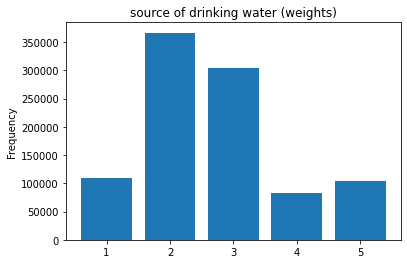

In [24]:
for col in ["source of drinking water (weights)"]:
    hist = df[col].plot.hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8)
#     plt.xlim(0.5, 5.5)
    plt.title(col)
    plt.show()

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


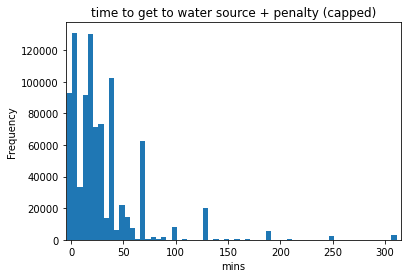

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


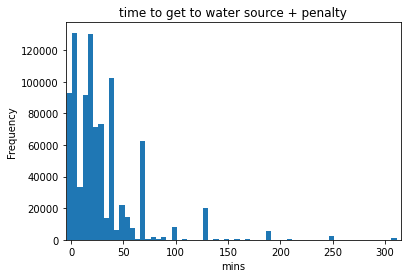

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


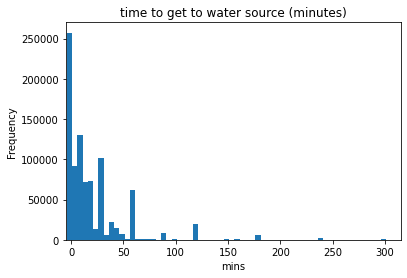

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


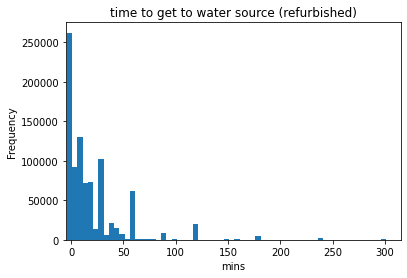

In [25]:
for col in ["time to get to water source + penalty (capped)", "time to get to water source + penalty",
            "time to get to water source (minutes)", "time to get to water source (refurbished)"]:
    bins = list(range(-4, 315, 5))
    print(bins)
    hist = df[col].plot.hist(bins=bins)
    plt.xlim(-5, 315)
    plt.title(col)
    plt.xlabel("mins")
    plt.show()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


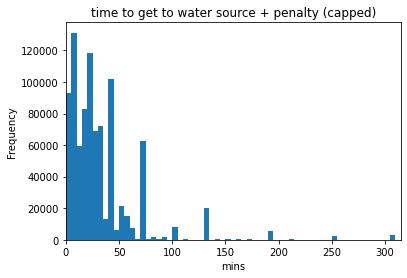

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


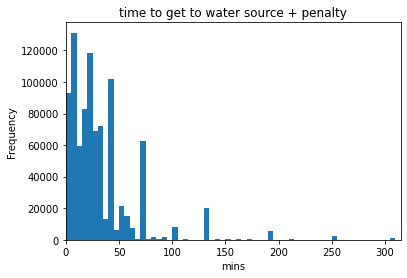

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


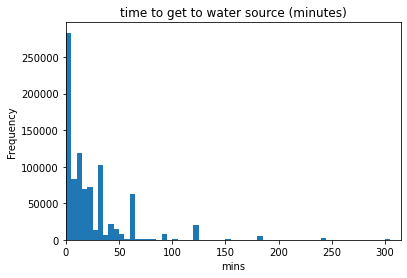

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


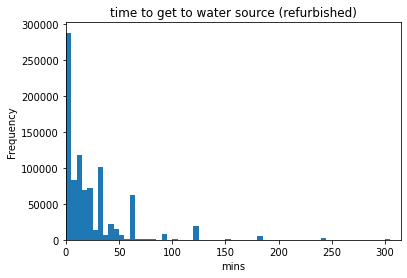

In [26]:
for col in ["time to get to water source + penalty (capped)", "time to get to water source + penalty",
            "time to get to water source (minutes)", "time to get to water source (refurbished)"]:
    bins = list(range(0, 315, 5))
    print(bins)
    hist = df[col].plot.hist(bins=bins)
    plt.xlim(0, 315)
    plt.title(col)
    plt.xlabel("mins")
    plt.show()

In [27]:
#create distance categories
df['distance categories'] = np.NaN
df['distance categories num'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories'])
        df['distance categories num'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num'])
df['distance categories 2'] = np.NaN
df['distance categories num 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories 2'])
        df['distance categories num 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num 2'])

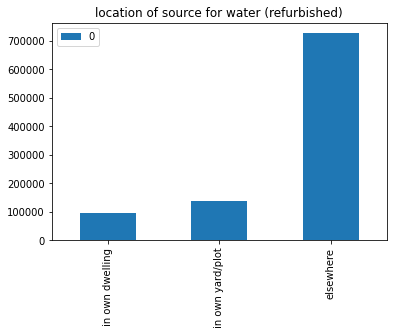

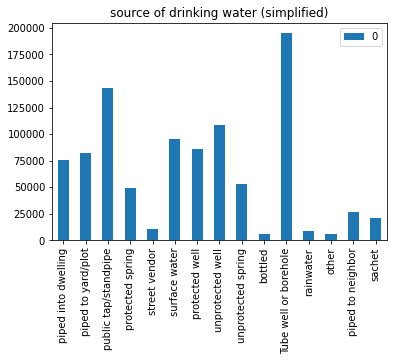

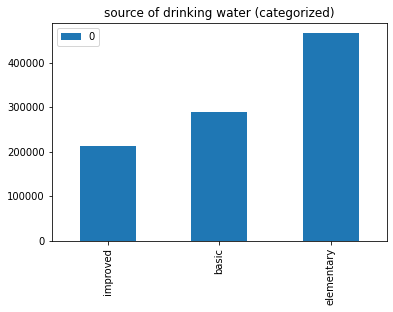

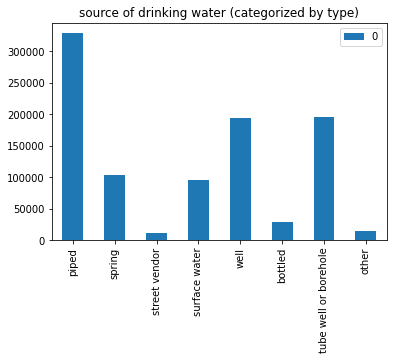

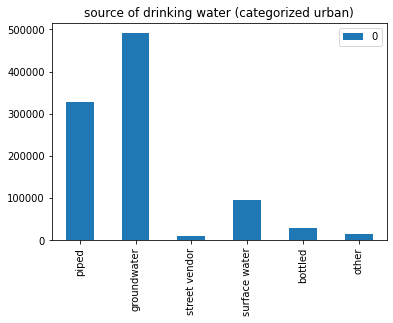

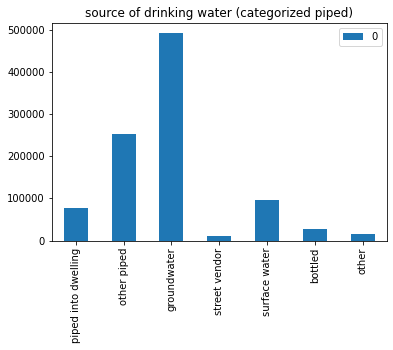

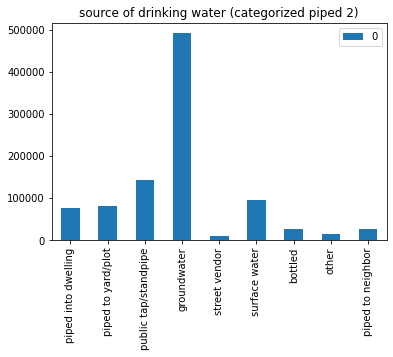

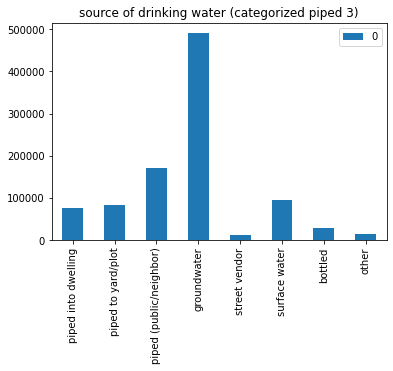

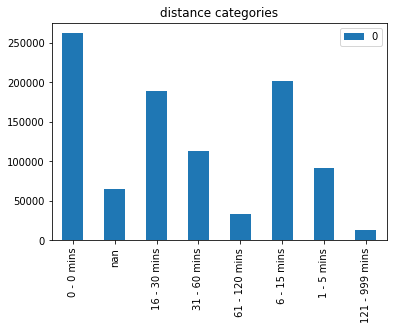

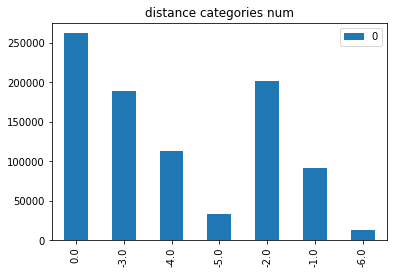

In [28]:
for col in ["location of source for water (refurbished)", "source of drinking water (simplified)",
           "source of drinking water (categorized)", "source of drinking water (categorized by type)",
           "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
           "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
           'distance categories', 'distance categories num']:
#     series = df[col].replace({np.NaN: None})
#     print(series)
    counts = Counter(df[col].dropna())
#     print(col, counts, type(counts))
    count_df = pd.DataFrame.from_dict(counts, orient='index')
    count_df.plot(kind='bar')
    plt.title(col)


In [29]:
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,TIF_name,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights),location of source for water (refurbished),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source + penalty,time to get to water source (refurbished) + penalty,time to get to water source + penalty (capped),distance categories,distance categories num,distance categories 2,distance categories num 2
0,1 1,AO5,1.0,1.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,in own dwelling,0.0,0.0,5.0,NaN,0.0,NaN,0 - 0 mins,0.0,0 - 5 mins,0.0
1,1 2,AO5,1.0,2.0,3.0,2011.0,6.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,in own dwelling,0.0,0.0,5.0,NaN,0.0,NaN,0 - 0 mins,0.0,0 - 5 mins,0.0
2,1 3,AO5,1.0,3.0,3.0,2011.0,9.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,in own dwelling,0.0,0.0,5.0,NaN,0.0,NaN,0 - 0 mins,0.0,0 - 5 mins,0.0
3,1 4,AO5,1.0,4.0,3.0,2011.0,5.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,in own dwelling,0.0,0.0,5.0,NaN,0.0,NaN,0 - 0 mins,0.0,0 - 5 mins,0.0
4,1 5,AO5,1.0,5.0,3.0,2011.0,3.0,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,AOGE61FL00000001.tif,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0,in own dwelling,0.0,0.0,5.0,NaN,0.0,NaN,0 - 0 mins,0.0,0 - 5 mins,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970631,400 25,ZW7,400.0,25.0,11.0,2015.0,5.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0,in own yard/plot,0.0,5.0,3.0,5.0,5.0,5.0,0 - 0 mins,0.0,0 - 5 mins,0.0
970632,400 26,ZW7,400.0,26.0,11.0,2015.0,2.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0,in own yard/plot,0.0,5.0,3.0,5.0,5.0,5.0,0 - 0 mins,0.0,0 - 5 mins,0.0
970633,400 27,ZW7,400.0,27.0,11.0,2015.0,5.0,mashonaland east,unprotected well,ZWGE72FL,0.0,10.0,elsewhere,yes,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,unprotected well,well,groundwater,groundwater,groundwater,groundwater,elementary,2.0,elsewhere,10.0,10.0,1.0,20.0,20.0,20.0,6 - 15 mins,-2.0,6 - 15 mins,-1.0
970634,400 28,ZW7,400.0,28.0,11.0,2015.0,8.0,mashonaland east,protected well,ZWGE72FL,0.0,0.0,in own yard/plot,no,NaN,ZW201500000400,ZWGE72FL00000400.tif,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,bas

In [30]:
# #create pca
# for col_l in [["source of drinking water (weights)", "distance categories num", "weighting (location)"]]: 
# # time to get to water source (refurbished)["source of drinking water (categorized urban)"]
#     ges_l = ["DHSID"] + col_l
#     sub_df = df[ges_l].dropna()
#     x = pd.DataFrame(sub_df.loc[:, col_l].values)
#     print(x)
#     x = StandardScaler().fit_transform(x)
#     print('x2', x)
#     pca = PCA(n_components=3)
#     print('pca', pca)
#     sub_df['PCA1'] = pca.fit_transform(x)[:, 0]

# # print the varianz distribution of the principle components
# varianz_of_pcs = pca.explained_variance_ratio_
# for pc_i, pc_v in enumerate(varianz_of_pcs):
#     print("Varianz of pc{}: {}".format(pc_i+1, pc_v))    
# sub_df



In [31]:
df2 = df
for n1, col_l in zip(['cat_distance', 'min', 'w_weighting', 'w_penalty'], 
                     [["source of drinking water (weights)", "distance categories num"],
             ["source of drinking water (weights)", 'time to get to water source (refurbished)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished)',
             'weighting (location)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished) + penalty']]): 
    for name, ind in {'urban': 'U', 'rural': 'R', 'all': 'a'}.items():
        ges_l = ["DHSID", "cluster number", "URBAN_RURA"] + col_l
        sub_df = df[ges_l].dropna()
        if name != 'all':
            sub_df = sub_df[sub_df["URBAN_RURA"] == ind]
        features = sub_df[col_l]
        col_n = 'PCA ' + n1 + ' ' + name
#         features["source of drinking water (weights)"] = -features["source of drinking water (weights)"]
#         features["distance categories num"] = -features["distance categories num"]
#         if "time to get to water source (refurbished)" in features.columns:
#             features["time to get to water source (refurbished)"] = -features["time to get to water source (refurbished)"]
#         print(name)
#         print('f', features)
        T = StandardScaler().fit_transform(features)
#         t2 = pd.DataFrame(T, columns=col_l)
#         print(t2)
        # apply the pca analysis
        pca_model = PCA(n_components=2)
        pca_model.fit(T)
        I = pca_model.transform(T)
#         print('I', I)
        sub_df[col_n] = I[:, 0]
        # print the varianz distribution of the principle components
        varianz_of_pcs = pca_model.explained_variance_ratio_
        print(name)
#         ax2 = sns.displot(sub_df[col_n], stat='probability')
#         print(sub_df)
        df2 = pd.merge(df2, sub_df[col_n], left_index=True, right_index=True, how='left')
        features['PCA'] = I[:,0]
        print(n1, name)
        corr_value = features.corr(method="pearson")
        for pc_i, pc_v in enumerate(varianz_of_pcs):
            print("Varianz of pc{}: {}".format(pc_i+1, pc_v))
#         pearson_corr = corr_value["Prediction"][1]
        print(corr_value.head())
        print('components', pca_model.components_)
        print('explained variance', pca_model.explained_variance_ratio_)
        print('singular values', pca_model.singular_values_)
        print('mean', pca_model.mean_)
        
        loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

        fig = px.scatter(I, x=0, y=1)#, color=col_l)

        for i, feature in enumerate(col_l):
            fig.add_shape(
                type='line',
                x0=0, y0=0,
                x1=loadings[i, 0],
                y1=loadings[i, 1]
            )
            fig.add_annotation(
                x=loadings[i, 0],
                y=loadings[i, 1],
                ax=0, ay=0,
                xanchor="center",
                yanchor="bottom",
                text=feature,
            )
        fig.write_image(projects_p + '/imgs/pca/' + n1 + '_' + ind + '.png')
#         fig.show(projects_p + '/pca/' + n1)
        
        
        
        
#         print('df', df)

# df2[col_l + ["PCA urban"]].dropna()

urban


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['PCA'] = I[:,0]


cat_distance urban
Varianz of pc1: 0.7755676737479513
Varianz of pc2: 0.22443232625204868
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.551135 -0.880663
distance categories num                                       0.551135                 1.000000 -0.880663
PCA                                                          -0.880663                -0.880663  1.000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.77556767 0.22443233]
singular values [697.29731064 375.10326654]
mean [ 6.96346071e-17 -4.46096702e-17]
rural


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance rural
Varianz of pc1: 0.6759101713780573
Varianz of pc2: 0.32408982862194274
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.351820  0.822138
distance categories num                                       0.351820                 1.000000  0.822138
PCA                                                           0.822138                 0.822138  1.000000
components [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.67591017 0.32408983]
singular values [886.49839506 613.85551684]
mean [4.98670224e-17 1.04525190e-16]
all


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance all
Varianz of pc1: 0.7606323075108578
Varianz of pc2: 0.2393676924891422
                                    source of drinking water (weights)  distance categories num       PCA
source of drinking water (weights)                            1.000000                 0.521265 -0.872142
distance categories num                                       0.521265                 1.000000 -0.872142
PCA                                                          -0.872142                -0.872142  1.000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.76063231 0.23936769]
singular values [1166.72440306  654.50604833]
mean [ 1.87781507e-16 -4.65006980e-17]
urban


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min urban
Varianz of pc1: 0.6300004920953147
Varianz of pc2: 0.3699995079046853
                                           source of drinking water (weights)  time to get to water source (refurbished)       PCA
source of drinking water (weights)                                   1.000000                                  -0.260001 -0.793726
time to get to water source (refurbished)                           -0.260001                                   1.000000  0.793726
PCA                                                                 -0.793726                                   0.793726  1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.63000049 0.36999951]
singular values [628.46136596 481.62465831]
mean [ 6.96346071e-17 -1.74086518e-17]
rural


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min rural
Varianz of pc1: 0.5824138647891088
Varianz of pc2: 0.4175861352108912
                                           source of drinking water (weights)  time to get to water source (refurbished)      PCA
source of drinking water (weights)                                   1.000000                                  -0.164828 -0.76316
time to get to water source (refurbished)                           -0.164828                                   1.000000  0.76316
PCA                                                                 -0.763160                                   0.763160  1.00000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.58241386 0.41758614]
singular values [822.90426889 696.79736239]
mean [ 4.98670224e-17 -9.09339821e-18]
all


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min all
Varianz of pc1: 0.6271599925542777
Varianz of pc2: 0.3728400074457222
                                           source of drinking water (weights)  time to get to water source (refurbished)       PCA
source of drinking water (weights)                                   1.000000                                  -0.254320 -0.791934
time to get to water source (refurbished)                           -0.254320                                   1.000000  0.791934
PCA                                                                 -0.791934                                   0.791934  1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.62715999 0.37284001]
singular values [1059.42464315  816.84969577]
mean [ 1.87781507e-16 -5.15827415e-17]
urban


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_weighting urban
Varianz of pc1: 0.614927309965123
Varianz of pc2: 0.27472254007127084
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.260020              0.668349 -0.868660
time to get to water source (refurbished)                           -0.260020                                   1.000000             -0.285889  0.564605
weighting (location)                                                 0.668349                                  -0.285889              1.000000 -0.878313
PCA                                                                 -0.868660                                   0.564605             -0.878313  1.000000
components [[-0.63955401  0.41569271 -0.64666084]
 [ 0.31775436  0.90891384  0.27001446]]
explained variance [0.61492731 0.27472254]
singular value

/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_weighting rural
Varianz of pc1: 0.5479734594132721
Varianz of pc2: 0.2925865751816901
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.164831              0.514962 -0.809669
time to get to water source (refurbished)                           -0.164831                                   1.000000             -0.241884  0.524505
weighting (location)                                                 0.514962                                  -0.241884              1.000000 -0.844542
PCA                                                                 -0.809669                                   0.524505             -0.844542  1.000000
components [[-0.63149062  0.40908091 -0.65868992]
 [ 0.37729702  0.90426515  0.1998787 ]]
explained variance [0.54797346 0.29258658]
singular value

/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_weighting all
Varianz of pc1: 0.6093607954617439
Varianz of pc2: 0.273711912308146
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)       PCA
source of drinking water (weights)                                   1.000000                                  -0.254343              0.647908 -0.859116
time to get to water source (refurbished)                           -0.254343                                   1.000000             -0.291759  0.571674
weighting (location)                                                 0.647908                                  -0.291759              1.000000 -0.873608
PCA                                                                 -0.859116                                   0.571674             -0.873608  1.000000
components [[-0.63540989  0.42281529 -0.64612809]
 [ 0.33493303  0.90486544  0.26275159]]
explained variance [0.6093608  0.27371191]
singular values [

/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty urban
Varianz of pc1: 0.662319412699592
Varianz of pc2: 0.337680587300408
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty      PCA
source of drinking water (weights)                                            1.000000                                          -0.324639   -0.81383
time to get to water source (refurbished) + pen...                           -0.324639                                           1.000000    0.81383
PCA                                                                          -0.813830                                           0.813830    1.00000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.66231941 0.33768059]
singular values [644.36638632 460.09994586]
mean [-1.81347644e-16 -2.75648418e-17]
rural


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty rural
Varianz of pc1: 0.5958445664291536
Varianz of pc2: 0.4041554335708464
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty      PCA
source of drinking water (weights)                                            1.000000                                          -0.191689   -0.77191
time to get to water source (refurbished) + pen...                           -0.191689                                           1.000000    0.77191
PCA                                                                          -0.771910                                           0.771910    1.00000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.59584457 0.40415543]
singular values [832.27974095 685.45199162]
mean [-1.02975259e-16 -2.88487194e-17]
all


/tmp/ipykernel_1564826/836372909.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty all
Varianz of pc1: 0.6490245786026112
Varianz of pc2: 0.35097542139738885
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty       PCA
source of drinking water (weights)                                            1.000000                                          -0.298049   -0.805621
time to get to water source (refurbished) + pen...                           -0.298049                                           1.000000    0.805621
PCA                                                                          -0.805621                                           0.805621    1.000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.64902458 0.35097542]
singular values [1077.67650424  792.49438623]
mean [-1.99618451e-16  6.80748475e-17]


In [36]:
df3 = df2[["PCA w_weighting urban", 'water shortages', "source of drinking water (weights)", "time to get to water source (refurbished)"]].dropna()
print(scipy.stats.pointbiserialr(df3["PCA w_weighting urban"], df3['water shortages']))
df3

PointbiserialrResult(correlation=-0.040248107470223886, pvalue=7.894749549896344e-30)


,PCA w_weighting urban,water shortages,source of drinking water (weights),time to get to water source (refurbished)
8160,-2.137656,1.0,5.0,0.0
8162,0.618354,0.0,3.0,0.0
8163,-0.759651,1.0,4.0,0.0
8164,0.618354,1.0,3.0,0.0
8165,-2.137656,1.0,5.0,0.0
...,...,...,...,...
970603,1.189050,0.0,2.0,1.0
970604,1.542307,0.0,2.0,30.0
970605,1.237775,0.0,2.0,5.0
970606,1.359588,0.0,2.0,15.0


In [ ]:
df = df2

In [ ]:
cluster_df = df.groupby('DHSID').mean()
cluster_df

In [ ]:
cluster_dfb = pd.merge(cluster_df, locations_df, how="left", on="DHSID")
cluster_dfb[cluster_dfb["LATNUM"].notna()]

In [ ]:
# cluster_dfc1 = df.groupby('DHSID').mean()
# cluster_dfc2 = pd.merge(cluster_dfc1, locations_df, how="left", left_on="alt_DHSID", right_on="DHSID")
# cluster_dfc2

In [ ]:
join_df = pd.DataFrame(df[["DHSID", "TIF_name"]].value_counts(dropna=False)).reset_index()
join_df.rename(columns={0: "households"}, inplace=True)
join_df[join_df["households"] <= 2]

In [ ]:
cluster_df2 = pd.merge(cluster_dfb, join_df, on="DHSID")
cluster_df2

In [ ]:
tif_f_shannon = {}
tif_f_stoermer = {}
for (dirrpath, dirrnames, filenames) in os.walk(walk_f):
#     print(dirrpath, dirrnames, filenames)
    for f in filenames:
        if f[-4:].lower() == '.tif':
            if not 'VIIRS' in dirrpath:
                if '/water_new' in dirrpath:
                    tif_f_shannon[f] = dirrpath + '/' + f
                elif '/asset/' in dirrpath and '/all' in dirrpath:
                    tif_f_stoermer[f] = dirrpath + '/' + f
for nr, (f, p) in enumerate(tif_f_shannon.items()):
    if not nr % 100:
        print(nr, f, p)
for nr, (f, p) in enumerate(tif_f_stoermer.items()):
    if not nr % 100:
        print(nr, f, p)

In [ ]:
tif_shannon_df = pd.DataFrame.from_dict(tif_f_shannon, orient='index', columns=["path"]).reset_index()
tif_shannon_df.rename(columns={"index": "TIF_name"}, inplace=True)
tif_shannon_df

In [ ]:
cluster_df3 = pd.merge(cluster_df2, tif_shannon_df, how="left", on='TIF_name')
cluster_df3[cluster_df3["path"].notna()]

In [ ]:
df_all = cluster_df3.merge(tif_shannon_df, on="path", 
                   how='outer', indicator=True)
print(df_all[df_all["_merge"] == "right_only"]["path"].value_counts()[:400])

In [ ]:
#Caution some (very little ~5) of the stoermer tifs are not mapped correctly (needs to also be checked for year ~5)
# trunc_nr = 10000
# cluster_df3["LATNUM"] = np.trunc(trunc_nr * cluster_df3["LATNUM"].astype(float)) / trunc_nr
# cluster_df3["LONGNUM"] = np.trunc(trunc_nr * cluster_df3["LONGNUM"].astype(float)) / trunc_nr

# tif_stoermer_df = pd.DataFrame.from_dict(tif_f_stoermer, orient='index', columns=["path"]).reset_index()
# tif_stoermer_df.rename(columns={"index": "TIF_name"}, inplace=True)
# tif_names_df = tif_stoermer_df["TIF_name"].str.split('_', n = 5, expand = True)#, columns=["LONGNUM", "LATNUM", "YEARS", 
# # tif_stoermer_df["LONGNUM"]                                                                        #          "Country_code", "U/R", "REST"])
# tif_stoermer_df["LATNUM"] = np.trunc(trunc_nr * tif_names_df[0].astype(float)) / trunc_nr
# tif_stoermer_df["LONGNUM"] = np.trunc(trunc_nr * tif_names_df[1].astype(float)) / trunc_nr
# # tif_stoermer_df
# tif_stoermer_df

In [ ]:
#Caution ~5 images are appearing 2 times
# cluster_df4 = pd.merge(cluster_df3, tif_stoermer_df, how="left", on=['LATNUM', 'LONGNUM'])
# cluster_df4[cluster_df4["path_x"].notna()]

In [ ]:
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df.rename(columns=replace_d)
stddev_df
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df =stddev_df.rename(columns=replace_d)
stddev_df

In [ ]:
cluster_df5 = pd.merge(cluster_df3, stddev_df, how="left", on=['DHSID'])
cluster_df5

In [ ]:
for col in ["source of drinking water (simplified)", "source of drinking water (categorized by type)", 
            "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
            "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)"]:
    count_df = pd.DataFrame(df.groupby("DHSID")[col].value_counts())
    count_df.columns = [col + ': counts']
    count_df = count_df.reset_index()
    count_df2 = count_df.pivot(index='DHSID', columns=col, 
                         values=col + ': counts')
    count_df2 = count_df2.fillna(0)
    count_df2 = count_df2.rename(columns={c: col + ': ' + str(c) for c in count_df2.columns})
    # count_df2 = count_df2.reset_index()
    # count_df
    cluster_df5 = pd.merge(cluster_df5, count_df2, how="outer", on=['DHSID'])
cluster_df5.to_csv(projects_p + 'new_labels.csv')

In [ ]:
cluster_df5

In [ ]:
if limit_calc_on_available_s2img:
    cluster_df6 = cluster_df5[cluster_df5["path"].notna()]
for pre in ["source of drinking water (simplified)", "source of drinking water (categorized by type)",
            "source of drinking water (categorized urban)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)",
           "source of drinking water (categorized piped)", "source of drinking water (categorized piped 2)",
           "source of drinking water (categorized piped 3)"]:
    pre += ':'
    select_cols = ["DHSID", "URBAN_RURA"]
    for col in cluster_df5.columns:
        if pre in col:
            select_cols.append(col)
    sub_df = cluster_df5[select_cols]
    print(pre)
    print(sub_df)
    sub_df[pre + ' max'] = sub_df[select_cols[2:]].idxmax(axis=1)
#     print(sub_df[pre + ' max'])
    for i, x in pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows():
        print('asd', x)
#     print(pd.DataFrame(sub_df[pre + ' max'].value_counts()))
    replace_d = {pre + ' max': {c: c[len(pre) + 1:] for c, v in 
                                     pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows()}}
    print(replace_d)
    sub_df = sub_df.replace(replace_d)
    print(sub_df)
    print(pre)
    sub_df[pre + ' perc max'] = sub_df[select_cols[1:]].max(axis=1) / sub_df[select_cols[1:]].sum(axis=1) * 100
    print(sub_df[pre + ' max'].value_counts(dropna=False))
#     plot perc max    
#     bins = list(range(1, 101, 5))
#     print(bins)
#     hist = sub_df[pre + ' perc max'].plot.hist(bins=bins)#, density=True)
#     plt.xlim(-5, 315)
#     plt.title(pre[:-1])
#     plt.xlabel("percentage of highest label")
#     plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    sub_df = sub_df[sub_df['URBAN_RURA'] == 'U']
    sns.displot(sub_df[pre + ' perc max'], stat='probability')
    ax2 = sns.displot(sub_df[pre + ' max'], stat='probability')
    for ax in [ax2]:
        if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
            ax.set_xticklabels(rotation=90)
#     plt.show()

    cluster_df6 = pd.merge(cluster_df6, sub_df[["DHSID", pre + ' max', pre + ' perc max']], how="outer", on=['DHSID'])
    
cluster_df6

In [ ]:
cluster_df6['distance categories cluster'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster'])
cluster_df6['distance categories cluster 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster 2'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster 2'])
cluster_df6

In [ ]:
if split_urban_rural:
    files = {'U': out_f[:-4] + '_urban.csv', 'R': out_f[:-4] + '_rural.csv'}
else:
    files = {'all': out_f}
for indi, file in files.items():
    if indi != 'all':
        sub_df = cluster_df6[cluster_df6["URBAN_RURA"] == indi]
    else:
        sub_df = cluster_df6
    #create train, validation, test
    for mode in ['random split', "split (forced all <=2015 to train)"]:
        if mode == "split (forced all <=2015 to train)":
            sub_df2 = sub_df2.sort_values("DHSYEAR")
#             print(mode, sub_df2)
        else:
            sub_df2 = sub_df[["year of interview", "DHSYEAR", "DHSID", "number of household members"]]
            sub_df2 = sub_df2.sample(frac=1)
#             print(mode, sub_df)
        sub_df2[mode] = 'train'
        sub_df2[mode][int(len(sub_df2) * train_ratio):] = 'validation'
        sub_df2[mode][int(len(sub_df2) * (1 - test_ratio)):] = 'test'
#         print(mode)
#         print(sub_df2[sub_df2[mode] == 'train'][:300])
#         print(sub_df2[sub_df2[mode] == 'validation'][:300])
#         print(sub_df2[sub_df2[mode] == 'test'][:300])
    
    sub_df = pd.merge(sub_df, sub_df2[["DHSID", 'random split', "split (forced all <=2015 to train)"]], how="outer", on=['DHSID'])
    if indi == 'U':
        urban_df = sub_df
    for col in sub_df.columns:
        if 'PCA' in col and ('urban' in col or 'all' in col) and not 'Std Deviation' in col:
            sub_df[col] = sub_df[col] * (-1)
    sub_df.to_csv(file, na_rep='')
    print(sub_df.columns)
    for col in sub_df.columns:
        if 'max' in col or 'PCA' in col or col in ['time to get to water source (minutes)',
                                   'time to get to water source (refurbished)', 'time to get to water source + penalty (capped)',
                'source of drinking water (weights)', 'Std Deviation: time to get to water source (refurbished)',
                                  'distance categories cluster']:
#             ax1 = sns.displot(sub_df[col])#, stat='probability')
            if not sub_df[col].dropna().empty:
                sub_sub_df = sub_df[col]
                
                print(col)
                print(sub_df[col])
                print(max(sub_df[col].dropna()))
                print(type(max(sub_df[col].dropna())))
                if not type(max(sub_df[col].dropna())) == str and max(sub_df[col].dropna()) >= 120:
                    bins = list(range(0, 121, 5))
                    print('asdfg', len(sub_df[sub_df[col] <= 1][col].dropna())/len(sub_df[col].dropna()))
                    ax2 = sns.displot(sub_df[col], stat='probability', bins=bins)
                else:
                    ax2 = sns.displot(sub_df[col], stat='probability')
                for ax in [ax2]:
                    if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
                        ax.set_xticklabels(rotation=90)

                plt.xlabel('')
                title = col
                if col == 'source of drinking water (simplified): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (simplified): perc max':
                    title = 'Source of drinking water (Percentage of max category)'
                if col == 'PCA w_weighting urban':
                    title = 'PCA'
                if col == 'Std Deviation: PCA w_weighting urban':
                    title = 'Std Deviation: PCA'
                if col == 'time to get to water source (refurbished)':
                    title = 'Time to get to water source (mins)'
                if col == 'location of source for water (refurbished): max':
                    title = 'Location of source for water'
                if col == 'source of drinking water (categorized urban): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized urban): perc max':
                    title = 'Source of drinking water (Percentage of max category)'
                if col == 'source of drinking water (categorized piped): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped): perc max':
                    title = 'Source of drinking water (Percentage of max category)'
                if col == 'source of drinking water (categorized piped 2): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 2): perc max':
                    title = 'Source of drinking water (Percentage of max category)'
                if col == 'source of drinking water (categorized piped 3): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 3): perc max':
                    title = 'Source of drinking water (Percentage of max category)'

                title += ' (n=' + str(len(sub_df[col].dropna())) + ')'
                plt.title(title)





In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

if split_urban_rural:
    files = {'U': out_f[:-4] + '_urban.csv', 'R': out_f[:-4] + '_rural.csv'}
else:
    files = {'all': out_f}
for indi, file in files.items():
    if indi != 'all':
        sub_df = cluster_df6[cluster_df6["URBAN_RURA"] == indi]
    else:
        sub_df = cluster_df6
    #create train, validation, test
    for mode in ['random split', "split (forced all <=2015 to train)"]:
        if mode == "split (forced all <=2015 to train)":
            sub_df2 = sub_df2.sort_values("DHSYEAR")
#             print(mode, sub_df2)
        else:
            sub_df2 = sub_df[["year of interview", "DHSYEAR", "DHSID", "number of household members"]]
            sub_df2 = sub_df2.sample(frac=1)
#             print(mode, sub_df)
        sub_df2[mode] = 'train'
        sub_df2[mode][int(len(sub_df2) * train_ratio):] = 'validation'
        sub_df2[mode][int(len(sub_df2) * (1 - test_ratio)):] = 'test'
#         print(mode)
#         print(sub_df2[sub_df2[mode] == 'train'][:300])
#         print(sub_df2[sub_df2[mode] == 'validation'][:300])
#         print(sub_df2[sub_df2[mode] == 'test'][:300])
    
    sub_df = pd.merge(sub_df, sub_df2[["DHSID", 'random split', "split (forced all <=2015 to train)"]], how="outer", on=['DHSID'])
    if indi == 'U':
        urban_df = sub_df
    for col in sub_df.columns:
        if 'PCA' in col and ('urban' in col or 'all' in col) and not 'Std Deviation' in col:
            sub_df[col] = sub_df[col] * (-1)
    sub_df.to_csv(file, na_rep='')
    print(sub_df.columns)
    for col in sub_df.columns:
        if 'max' in col or 'PCA' in col or col in ['time to get to water source (minutes)',
                                   'time to get to water source (refurbished)', 'time to get to water source + penalty (capped)',
                'source of drinking water (weights)', 'Std Deviation: time to get to water source (refurbished)',
                                  'distance categories cluster']:
#             ax1 = sns.displot(sub_df[col])#, stat='probability')
            if not sub_df[col].dropna().empty:
                sub_sub_df = pd.DataFrame(sub_df[col], columns=[col])
                print(col)
                print(sub_sub_df)
                if 'max' in col and not col =='source of drinking water (simplified)':
                    replace_d = {}
                    values_df = pd.DataFrame(sub_sub_df.value_counts(), columns=[col])
                    for nr, row in enumerate(values_df.iterrows()):   
                        print(nr, row)
                        print('asd', row[0][0], row[1][col])
                        if row[1][col] >= len(sub_sub_df[col]) * 0.05:                                                             
                            replace_d[row[0][0]] = np.NaN                                                                  
#                             if cfg.verbose:                                                                             
#                                 print('dropped label:', row[0], 'n:', row[1][col], '< threshold', len(labels_df) * drop)
                    sub_sub_df.replace(replace_d)
                sub_sub_df = sub_sub_df.dropna()
                print(max(sub_sub_df))
                print(type(max(sub_sub_df)))
                print(sub_sub_df)
#                 figure = plt.figure(figsize=(2, 1), dpi=300)
#                 sns.set(font_scale = 1)
                if not type(max(sub_sub_df[col])) == str and max(sub_sub_df[col]) >= 120:
                    bins = list(range(0, 80, 5))
                    print('asdfg', len(sub_sub_df[sub_sub_df <= 1])/len(sub_sub_df))
                    ax2 = sns.displot(sub_sub_df[col], stat='probability', bins=bins)
                else:
                    ax2 = sns.displot(sub_sub_df[col], stat='probability')
                for ax in [ax2]:
                    if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
                        ax.set_xticklabels(rotation=90)

                title = col
                extra_folder = ''
                x_title = None
#                 sns.set_style("whitegrid")
                if col == 'source of drinking water (simplified): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (simplified): perc max':
                    title = 'Source of drinking water'
                if col == 'PCA w_weighting urban':
                    title = 'PCA'
                    x_title = 'Distribution of first principle component'
                if col == 'Std Deviation: PCA w_weighting urban':
                    title = 'PCA'
                    x_title = 'Standard deviation of first principle component'
                if col == 'time to get to water source (refurbished)':
                    title = 'Time to get to water source'
                    x_title = 'Distance [mins]'
                if col == 'location of source for water (refurbished): max':
                    title = 'Location of source for water'
                if col == 'source of drinking water (categorized urban): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized urban): perc max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped): perc max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 2): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 2): perc max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 3): max':
                    title = 'Source of drinking water'
                if col == 'source of drinking water (categorized piped 3): perc max':
                    title = 'Source of drinking water'
                if title != col:
                    extra_folder = '/chosen/'
                if 'perc max' in col:
                    x_title = 'Share of answers in maximum category [%]'

                title += ' (n=' + str(len(sub_sub_df)) + ')'
                plt.title(title, fontsize=14)
                plt.xlabel(x_title, fontsize=14)
                plt.ylabel('Probability', fontsize=14)
                plt.grid(True)
#                 plt.tight_layout()

#                 plt.tightlayout()
                plt.savefig(projects_p + '/imgs/' + extra_folder + indi + '_' + col, dpi=300, 
                            bbox_inches="tight", transparent=False)





In [ ]:
# urban_df[urban_df["DHSID"].str[:2] =='MA']
# drop_countries = ['ZA', 'EG', 'TN', 'MA']
print(len(urban_df['country'].value_counts()))
urban_df['country'].value_counts()

In [ ]:
urban_df['DHS survey ID'] = urban_df['DHSID'].str[:6]
len(urban_df['DHS survey ID'].value_counts())

In [ ]:
df[(df['DHS survey ID'].isin(urban_df['DHS survey ID'].unique())) & (df['URBAN_RURA'] == 'U')]

In [ ]:
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

# if split_urban_rural:
#     files = {'U': out_f[:-4] + '_urban.csv', 'R': out_f[:-4] + '_rural.csv'}
# else:
#     files = {'all': out_f}
# for indi, file in files.items():
#     if indi != 'all':
#         sub_df = cluster_df6[cluster_df6["URBAN_RURA"] == indi]
#     else:
#         sub_df = cluster_df6
#     #create train, validation, test
#     for mode in ['random split', "split (forced all <=2015 to train)"]:
#         if mode == "split (forced all <=2015 to train)":
#             sub_df2 = sub_df2.sort_values("DHSYEAR")
# #             print(mode, sub_df2)
#         else:
#             sub_df2 = sub_df[["year of interview", "DHSYEAR", "DHSID", "number of household members"]]
#             sub_df2 = sub_df2.sample(frac=1)
# #             print(mode, sub_df)
#         sub_df2[mode] = 'train'
#         sub_df2[mode][int(len(sub_df2) * train_ratio):] = 'validation'
#         sub_df2[mode][int(len(sub_df2) * (1 - test_ratio)):] = 'test'
# #         print(mode)
# #         print(sub_df2[sub_df2[mode] == 'train'][:300])
# #         print(sub_df2[sub_df2[mode] == 'validation'][:300])
# #         print(sub_df2[sub_df2[mode] == 'test'][:300])
    
#     sub_df = pd.merge(sub_df, sub_df2[["DHSID", 'random split', "split (forced all <=2015 to train)"]], how="outer", on=['DHSID'])
#     if indi == 'U':
#         urban_df = sub_df
#     for col in sub_df.columns:
#         if 'PCA' in col and ('urban' in col or 'all' in col) and not 'Std Deviation' in col:
#             sub_df[col] = sub_df[col] * (-1)
#     sub_df.to_csv(file, na_rep='')
#     print(sub_df.columns)
#     fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey=True)
#     chosen_cols = ['source of drinking water (simplified): max', 'location of source for water (refurbished): max',
#                   'PCA w_weighting urban', 'time to get to water source (refurbished)']
#     for col in sub_df.columns:
#         if col in chosen_cols:
# #             ax1 = sns.displot(sub_df[col])#, stat='probability')
#             if not sub_df[col].dropna().empty:
#                 sub_sub_df = pd.DataFrame(sub_df[col], columns=[col])
#                 print(col)
#                 sub_sub_df = sub_sub_df.dropna()
#                 print(max(sub_sub_df))
#                 print(type(max(sub_sub_df)))
#                 print(sub_sub_df)
#                 if not type(max(sub_sub_df[col])) == str and max(sub_sub_df[col]) >= 60:
#                     bins = list(range(0, 60, 5))
#                     print('asdfg', len(sub_sub_df[sub_sub_df <= 1])/len(sub_sub_df))
#                     nr = chosen_cols.index(col)
#                     if nr <= 1:
#                         t = (0, nr)
#                     else:
#                         t = (1, nr - 2)
#                     sns.displot(sub_sub_df[col], ax=t, stat='probability', bins=bins)
#                 else:
#                     sns.displot(sub_sub_df[col], ax=t, stat='probability')
#                 if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
#                     axes[t].set_xticklabels(rotation=90)

#                 title = col
#                 extra_folder = ''
#                 if col == 'source of drinking water (simplified): max':
#                     title = 'Source of drinking water'
#                 if col == 'source of drinking water (simplified): perc max':
#                     title = 'Source of drinking water (Percentage of max category)'
#                 if col == 'PCA w_weighting urban':
#                     title = 'PCA'
#                 if col == 'Std Deviation: PCA w_weighting urban':
#                     title = 'Std Deviation: PCA'
#                 if col == 'time to get to water source (refurbished)':
#                     title = 'Time to get to water source (mins)'
#                 if col == 'location of source for water (refurbished): max':
#                     title = 'Location of source for water'
#                 if col == 'source of drinking water (categorized urban): max':
#                     title = 'Source of drinking water'
#                 if col == 'source of drinking water (categorized urban): perc max':
#                     title = 'Source of drinking water (Percentage of max category)'
#                 if col == 'source of drinking water (categorized piped): max':
#                     title = 'Source of drinking water'
#                 if col == 'source of drinking water (categorized piped): perc max':
#                     title = 'Source of drinking water (Percentage of max category)'
#                 if col == 'source of drinking water (categorized piped 2): max':
#                     title = 'Source of drinking water'
#                 if col == 'source of drinking water (categorized piped 2): perc max':
#                     title = 'Source of drinking water (Percentage of max category)'
#                 if col == 'source of drinking water (categorized piped 3): max':
#                     title = 'Source of drinking water'
#                 if col == 'source of drinking water (categorized piped 3): perc max':
#                     title = 'Source of drinking water (Percentage of max category)'
#                 if title != col:
#                     extra_folder = '/chosen/'

#                 title += ' (n=' + str(len(sub_sub_df)) + ')'
#                 plt.xlabel(title)

# #                 plt.title(title)
# #                 plt.tightlayout()
#     plt.savefig(projects_p + '/imgs/' + 'multiplot', dpi=300, 
#                     bbox_inches="tight", transparent=False)



